# PROJEKT ZALICZNIOWY PAD
#### Analiza urazów serca
#### S34686 KONRAD OBREBSKI

# **0.** Accessing Data

In [242]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: ucimlrepo in c:\users\konrad\appdata\local\programs\python\python313\lib\site-packages (0.0.7)



In [243]:
#DS libraries 
#1.data & stats
import math
from scipy import stats
import pandas as pd
import numpy as np
#2. visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import dash
from dash import dcc, html, Input, Output
import dash_bootstrap_components as dbc
#3.ML
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

In [244]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
heart_disease
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
Y = heart_disease.data.targets 
  

# variable information 
print(heart_disease.variables) 


        name     role         type demographic  \
0        age  Feature      Integer         Age   
1        sex  Feature  Categorical         Sex   
2         cp  Feature  Categorical        None   
3   trestbps  Feature      Integer        None   
4       chol  Feature      Integer        None   
5        fbs  Feature  Categorical        None   
6    restecg  Feature  Categorical        None   
7    thalach  Feature      Integer        None   
8      exang  Feature  Categorical        None   
9    oldpeak  Feature      Integer        None   
10     slope  Feature  Categorical        None   
11        ca  Feature      Integer        None   
12      thal  Feature  Categorical        None   
13       num   Target      Integer        None   

                                          description  units missing_values  
0                                                None  years             no  
1                                                None   None             no  
2              

### krótkie objaśnienie danych
1. **age** -> wiek w latach
2. **sex** -> Płeć: 1=mężczyzna, 2 kobieta
3. **cp** -> Ból w klatce piersiowej (1= typical angina, 2= atypical angina, 3= non-anginal pain, 4= asymptomatic)
4. **trestbps** -> spoczynkowe ciśnienie krwi
5. **chol** -> ilość cholesterolu we krwi w mm Hg
6. **fbs** -> (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. **restecg** -> wyniki elektrocardiografu (0-w normie, 1- zaburzenie ST-T, 2- hypertrofia wg kryt.Estes'a)
8. **thalach** -> maksimalne tętno
9. **exang**  -> angina wywołana wysiłkiem fizycznym (1 = tak; 0 = nie)
10. **oldpeak** -> obniżenie odcinka (w EKG)
11. **slope** -> naczylenie odcinka ST (1-w góre, 2- płaski, 3- w dół)
12. **ca** -> liczba głownych naczyć wieńcowych (0-3) które zostały zidentyfikowane i zabarwione za pomocą fluoroskopii.
13.  **thal** wynik thalassemi  (3= normal; 6 = fixed defect; 7 = reversable defect)
14. **num** -> diagnoza choroby serca

# **1.** Data Preprocessing
Przed rozpoczęciem pracy na danych warto upewnić się, że są one zgodne z zasadą 5 V <br>
Na tym etapie jednak naistotniejsze jest **Variecity** <br>
Należy uzupełnić braki w danych oraz przyjżeć się czy istniejące obserwacje są wiarygodne

In [245]:
# Formatowanie wyświelatnia
pd.set_option('display.float_format', '{:.2f}'.format)


#Łączenie X i Y do jednego dataframu
df = pd.concat([X, Y], axis=1)

missing_values = df.isnull().sum()
missing_values

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

In [246]:
missing_values = df.isnull().sum()
missing_values

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

In [247]:
#obsługa wartości NaN
mean_of_ca = df['ca'].value_counts().idxmax()
df['ca'] = df['ca'].replace(np.nan, mean_of_ca)

most_frequent_thal = df['thal'].mean()
df['thal'] = df['thal'].replace(np.nan, most_frequent_thal)

df.isnull().sum()


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [248]:
how_many_dups = df.duplicated().sum()
print(f"Dupes:{how_many_dups}")

Dupes:0


In [249]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00
mean,54.44,0.68,3.16,131.69,246.69,0.15,0.99,149.61,0.33,1.04,1.60,0.66,4.73,0.94
std,9.04,0.47,0.96,17.60,51.78,0.36,0.99,22.88,0.47,1.16,0.62,0.93,1.93,1.23
min,29.00,0.00,1.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,1.00,0.00,3.00,0.00
25%,48.00,0.00,3.00,120.00,211.00,0.00,0.00,133.50,0.00,0.00,1.00,0.00,3.00,0.00
50%,56.00,1.00,3.00,130.00,241.00,0.00,1.00,153.00,0.00,0.80,2.00,0.00,3.00,0.00
75%,61.00,1.00,4.00,140.00,275.00,0.00,2.00,166.00,1.00,1.60,2.00,1.00,7.00,2.00
max,77.00,1.00,4.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,3.00,3.00,7.00,4.00


In [250]:
#typy danych
df['age']=  df['age'].astype('int')
df['sex']= df['sex'].astype('category')
df['cp']= df['cp'].astype('category')
df['trestbps']= df['trestbps'].astype('int')
df['chol']= df['chol'].astype('int')
df['fbs']= df['fbs'].astype('category')
df['restecg'] = df['restecg'].astype('category')
df['thalach'] = df['thalach'].astype('int')
df['exang']= df['exang'].astype('category')
df['oldpeak']= df['oldpeak'].astype('category')
df['slope']= df['slope'].astype('category')
df['ca']= df['ca'].astype('category')
df['thal']= df['thal'].astype('category')
df['num']= df['num'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       303 non-null    int64   
 1   sex       303 non-null    category
 2   cp        303 non-null    category
 3   trestbps  303 non-null    int64   
 4   chol      303 non-null    int64   
 5   fbs       303 non-null    category
 6   restecg   303 non-null    category
 7   thalach   303 non-null    int64   
 8   exang     303 non-null    category
 9   oldpeak   303 non-null    category
 10  slope     303 non-null    category
 11  ca        303 non-null    category
 12  thal      303 non-null    category
 13  num       303 non-null    category
dtypes: category(10), int64(4)
memory usage: 15.3 KB


### Standaryzacja
celu usunięcia różnic w skalach, ułatwić działanie algorytmów i zwiększenia stabilności obliczeń <br>
warto wprowadzić skalowanie, w tym przypadku będziemy standarowywać zmienne nadając im rozkład normalny

In [251]:
def normal_scaler(DataFrame):
    df_copy = DataFrame.copy()
    num_cols = df_copy.select_dtypes(include=['number'])
    for column in num_cols:
        df_copy[column] = (df_copy[column] - df_copy[column].mean() )/df_copy[column].std()
    return(df_copy)


In [252]:
df.describe()

,age,trestbps,chol,thalach
count,303.00,303.00,303.00,303.00
mean,54.44,131.69,246.69,149.61
std,9.04,17.60,51.78,22.88
min,29.00,94.00,126.00,71.00
25%,48.00,120.00,211.00,133.50
50%,56.00,130.00,241.00,153.00
75%,61.00,140.00,275.00,166.00
max,77.00,200.00,564.00,202.00


In [253]:
df_normalized= normal_scaler(df)
df_normalized.describe()

,age,trestbps,chol,thalach
count,303.00,303.00,303.00,303.00
mean,-0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-2.81,-2.14,-2.33,-3.44
25%,-0.71,-0.66,-0.69,-0.70
50%,0.17,-0.10,-0.11,0.15
75%,0.73,0.47,0.55,0.72
max,2.50,3.88,6.13,2.29


# **2.** Exploratory Data Analysis
## **2.1** Patterns in Data

In [254]:
cont_var = df.select_dtypes('int')
df_long = cont_var.melt(var_name='Variable', value_name='Value')

fig = make_subplots(rows=2, cols=2, subplot_titles=cont_var.columns)
for i, col in enumerate(cont_var.columns):
    row = i // 2 + 1
    col_num = i % 2 + 1
    fig.add_trace(go.Box(y=df[col], name=col), row=row, col=col_num)

fig.update_layout(
    title='Wykresy pudełkowe zmiennych ciągłych',
    height=600,
    width=600,
)
fig.show()



In [255]:
px.imshow(df.select_dtypes('int').corr(), title='Korelacje pomiedzy zmiennymi ciągłymi')

## Wnioski:
najwięcej outlierów: <br>
 1. trestbps **9**
 2. chol **5** 


najmocniejsze korelacje to: <br>
 1. thalach : age **-0.39** 
 2. trestbps : age **+0.28**
 3. chol : age **+0.20**

 Warto przyjżeć się wykresom punktowym dla najmocniejszych korelacji


In [256]:
px.scatter(df,  'age', 'thalach',trendline='ols', title= 'Związek wieku i maksymalnego odnotowanego tętna')

In [257]:
px.scatter(df,  "age", "trestbps",trendline='ols', title= "Związek wieku i maksymalnego odnotowanego tętna")

### Wnioski:
1. Górna granica tętna z wiekiem spada
2. Ciśnienie tętniczne rośnie wraz z wiekiem 

In [258]:
px.histogram(df, 'age', nbins=6,  title="Wiek pacjentów kardiologii")

In [259]:
px.histogram(df['num'], title= 'Częstość wystawianych diagnoz',labels={'value': 'typ zdiagnozowanej choroby'})

### Wnioski
Jak widzimy większość pacjętów jest w grupie wiekowej 50-59, natomiat najmniej w 20-29<br>
Większość badanych wychodzi z gabinetu z diagnozą 0 - czyli zdrowym sercem, reszta ma diagnozę od 1 do 4, mówiące o stadium choroby (4 jest najcieższym i najrzadszym stadium)


A/b testing 
PCA


### A/B Testing
**Przetestujmy hipoteze o różnicach w poziomie cholesterolu z zależności od płci:** <br>
**H0** _nie ma znaczących różnić w poziomie cholersterolu wśród grup mężczyzn i kobiet._ <br>
**H0** _poziom cholesterolu kobiet różni się statystycznie od mężcznyzn._


In [260]:
df_grouped = df.groupby('sex')['chol'].agg(['mean','std', 'count'])


males = df_grouped[df_grouped.index == 0]
females = df_grouped[df_grouped.index == 1]
df_grouped

C:\Users\Konrad\AppData\Local\Temp\ipykernel_12292\3010840626.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,mean,std,count
sex,,,
0,261.75,64.90,97
1,239.60,42.65,206


In [261]:
t = (males['mean'] - females['mean']) / np.sqrt((males['std']**2 / males['count']) + (females['std']**2 / females['count']))

In [262]:
#tworzymy zmienną testową 
t = (males['mean'].iloc[0] - females['mean'].iloc[0]) / math.sqrt((males['std'].iloc[0]**2 / males['count'].iloc[0]) + (females['std'].iloc[0]**2 / females['count'].iloc[0]))

#test drustronny
p_val = stats.t.sf(abs(t), males['count'].iloc[0] +  females['count'].iloc[0] -2)*2
print(f"wartość statytyski testowej t= {t}, p_val= {p_val}")

wartość statytyski testowej t= 3.0642633275425495, p_val= 0.0023796170018157902


Ponieważ wartość p jest znacznie mniejsza niż typowy poziom istotności (np. 0.05), możemy **odrzucić hipotezę zerową**. Oznacza to, że **różnica między średnimi obu grup (1=mężczyźni, 0=kobiety) jest statystycznie istotna.**

### Reducja wymiarów PCA
Algortym PCA używając SVD redukuje wymiary danych do tych z najwyższą warniancją

In [263]:
X= df.drop('num', axis =1 )
pca = PCA(n_components=4)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

px.scatter(X_pca)


original shape:    (303, 13)
transformed shape: (303, 4)


## **2.2** BI Dashboards
W tej części zajmnieny się przygotowywaniem raportów mających na celu przybliżyć użytkonikom nie pracującymi z danymi wizualną ich reprezentację <br>
Aby w ten sposób umożliwić im samodzielne monitorowie, analizę i wyłapywanie wzorów ukrytych danych bez potrzeby angażowania eksperta od danych.

In [264]:
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Szablon dashboardu
app.layout = html.Div([
    dbc.Container([
        html.H1('Dashboard Pomiarów Kardiologicznych', className='text-center mt-3 mb-4'),

        dbc.Row([
            dbc.Col([
                html.Label('Wybierz zakres wieku:', className='fw-bold'),
                dcc.RangeSlider(
                    id='age-slider',
                    min=df['age'].min(),
                    max=df['age'].max(),
                    step=1,
                    marks={i: str(i) for i in range(df['age'].min(), df['age'].max() + 1, 5)},
                    value=[df['age'].min(), df['age'].max()]
                )
            ], width=6),
            dbc.Col([
                html.Label('Wybierz płeć:', className='fw-bold'),
                dcc.RadioItems(
                    id='sex-filter',
                    options=[
                        {'label': 'Mężczyźni', 'value': 1},
                        {'label': 'Kobiety', 'value': 0},
                        {'label': 'Wszystkie', 'value': 'All'}
                    ],
                    value='All',
                    inline=True
                )
            ], width=6),
        ], className='mb-4'),

        dbc.Row([
            dbc.Col([
                dcc.Graph(id='pie-chart')
            ], width=12),
        ]),

        dbc.Row([
            dbc.Col([
                dcc.Graph(id='grouped-bar-chart') #line-chart grouped-bar-chart
            ], width=12),
        ]),

        dbc.Row([
            dbc.Col([
                dcc.Graph(id='line-chart') 
            ], width=12),
        ]),
    ])
])

# Nadpisywanie wizualizacji
@app.callback(
    Output('grouped-bar-chart', 'figure'),
    [Input('age-slider', 'value'),
     Input('sex-filter', 'value')]
)
def update_grouped_bar_chart(age_range, selected_sex):
    filtered_df = df[(df['age'] >= age_range[0]) & (df['age'] <= age_range[1])] #filtruje na interesujący nas przedział wiekowy
    if selected_sex != 'All': # filtruje interesująca nas płeć
        filtered_df = filtered_df[filtered_df['sex'] == int(selected_sex)] 
    avg_values = filtered_df[['trestbps', 'chol', 'thalach']].mean().reset_index()
    avg_values.columns = ['Variable', 'Average']
    fig = px.bar(
        avg_values,
        x='Variable',
        y='Average',
        title='Średnie Wartości Ciśnienia, Cholesterolu i Tętna',
        labels={'Variable': 'Pomiar', 'Average': 'Średnia'},
        color='Variable'
    )
    return fig

@app.callback(
    Output('line-chart', 'figure'),
    [Input('age-slider', 'value'),
     Input('sex-filter', 'value')]
)
def update_line_chart(age_range, selected_sex):
    filtered_df = df[(df['age'] >= age_range[0]) & (df['age'] <= age_range[1])]
    if selected_sex != 'All':
        filtered_df = filtered_df[filtered_df['sex'] == int(selected_sex)]
    if filtered_df.empty:
        return px.line(title='Brak danych w wybranym zakresie')
    avg_values_by_age = filtered_df.groupby('age')[['trestbps', 'chol', 'thalach']].mean().reset_index()
    avg_values = avg_values_by_age.melt(id_vars='age', var_name='Variable', value_name='Average')
    fig = px.line(
        avg_values,
        x='age',
        y='Average',
        color='Variable',
        title='Średnie Wartości w zależności od wieku',
        labels={'age': 'Wiek', 'Average': 'Średnia', 'Variable': 'Pomiar'}
    )
    return fig

@app.callback(
    Output('pie-chart', 'figure'),
    [Input('age-slider', 'value'),
     Input('sex-filter', 'value')]
)
def update_pie_chart(age_range, selected_sex):
    filtered_df = df[(df['age'] >= age_range[0]) & (df['age'] <= age_range[1])]
    if selected_sex != 'All':
        filtered_df = filtered_df[filtered_df['sex'] == int(selected_sex)]
    count_data = filtered_df['num'].value_counts().reset_index()
    count_data.columns = ['num', 'Count']
    fig = px.pie(
        count_data,
        values='Count',
        names='num',
        title='Procentowy Rozkład Typów Diagnozy (0 = Zdrowy, 1-4 = Stadium choroby)',
        labels={'num': 'Typ'}
    )
    return fig

# Uruchamia wyświetlanie Dashboardu
if __name__ == '__main__':
    app.run_server(debug=True)


# **3.** Modelowanie statyczne i ML
W tym rozdziale zbudujemy kilka modeli uczenia maszynowego których zadaniem będzie wykrycie narażenia na chorobę. <br>
Jest to problem klasyfikacyjny będziemy rozpartywać target: **0-zdrowy, 1-chory**

In [265]:
# Przygotowanie danych do modelu
X = df.drop('num', axis=1)
y = df['num'].apply(lambda x: 0 if x == 0 else 1) # zmieniamy na zmienną binarną do klasyfikacji

# Podział na zbiory testowy i treningowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 3.1 Drzewa Decyzyjne

In [266]:
# Trening drzewa decyzyjnego z indeksem Giniego
dt_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_gini.fit(X_train, y_train)
score_gini = dt_gini.score(X_test, y_test)

dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_entropy.fit(X_train, y_train)
score_entropy = dt_entropy.score(X_test, y_test)

print(f"Dokładność (Gini): {score_gini:.4f}")
print(f"Dokładność (Entropia): {score_entropy:.4f}")

Dokładność (Gini): 0.6923
Dokładność (Entropia): 0.7582


## 3.2 Regresja Logistyczna

In [267]:

model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)


c:\Users\Konrad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [268]:
# Ocena modelu
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print("-"*53)
print(classification_report(y_test, y_pred))


[[41  7]
 [ 5 38]]
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        48
           1       0.84      0.88      0.86        43

    accuracy                           0.87        91
   macro avg       0.87      0.87      0.87        91
weighted avg       0.87      0.87      0.87        91



In [269]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Accuracy: 0.8681318681318682
Precision: 0.8444444444444444
F1 Score: 0.8636363636363636


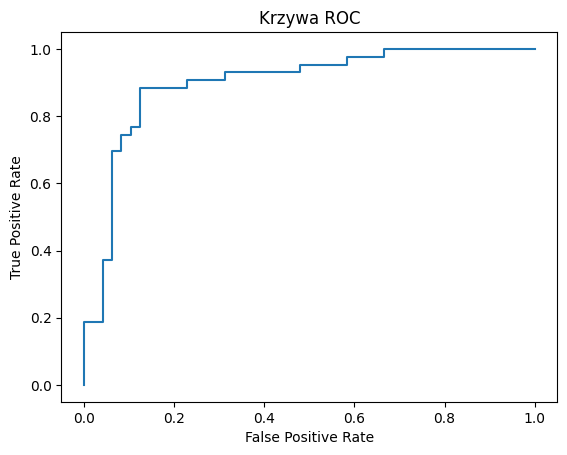

In [270]:
# Wizualizacja krzywej ROC
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.show()

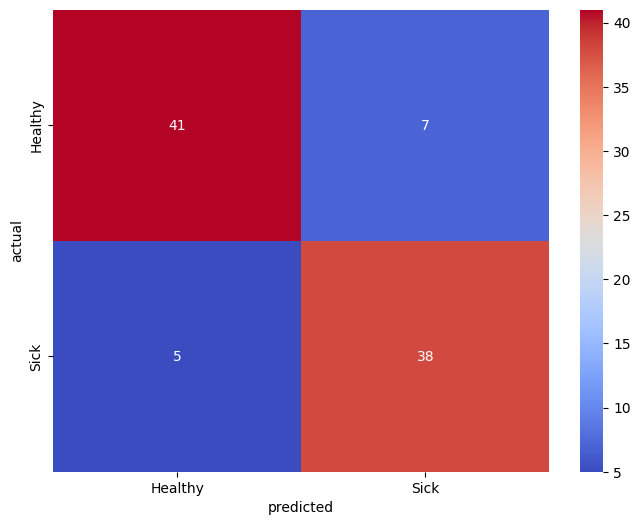

In [271]:

cm = confusion_matrix(y_test, y_pred)
labels=['Healthy', 'Sick']


def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=labels, yticklabels=labels)
  plt.xlabel('predicted')
  plt.ylabel('actual')

show_confusion_matrix(cm, labels)

In [272]:
# Przygotownie różnych da
feature_sets = {
    "Wszystkie cechy": df.drop("num", axis=1).columns.tolist(),
    "Top 3 cechy (bazujać na wiedzy medycznej)": ['cp', 'exang', 'thalach'],
    "Bez fbs": [col for col in df.drop("num", axis=1).columns if col != 'fbs']
}

In [273]:

results = []

for feature_set_name, feature_set in feature_sets.items():
    # Przygotuj dane
    X_train, X_test, y_train, y_test = train_test_split(df[feature_set], df["num"], test_size=0.3, random_state=42)
    # Trenuj
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Pomiary
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average= 'weighted')
    f1 = f1_score(y_test, y_pred, average= 'weighted')

    # Dodaj do listy wyników
    results.append({
        "Feature Set": feature_set_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "F1 Score": f1
    })


results_df = pd.DataFrame(results)

results_df

c:\Users\Konrad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\Konrad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Konrad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED L

,Feature Set,Accuracy,Precision,F1 Score
0,Wszystkie cechy,0.59,0.55,0.56
1,Top 3 cechy (bazujać na wiedzy medycznej),0.62,0.53,0.52
2,Bez fbs,0.60,0.57,0.59


### Wnioski
Jeśli Accuracy jest najważniejszym kryterium (np. ważne są tylko poprawne klasyfikacje bez względu na balans), wybierz model "Top 3 features". <br>
Jeśli zależy na zrównoważeniu Precision i Recall (np. w przypadku problemu związanego z klasyfikacją binarną, gdzie fałszywe pozytywy i negatywy są równie istotne), <br> najlepszy będzie model "Excluding fbs" ze względu na najwyższy F1 Score.
<br>
<br>
Rekomendacja opiera się na priorytetach problemu, ale w większości przypadków F1 Score jest lepszym wskaźnikiem dla zrównoważonej wydajności modelu, więc model **"Excluding fbs" wydaje się optymalnym wyborem.**

## 3.3 SVC i RandomForestClassyfier

Dokładność: 0.6593
Precycja: 0.7143
F1-score: 0.5634


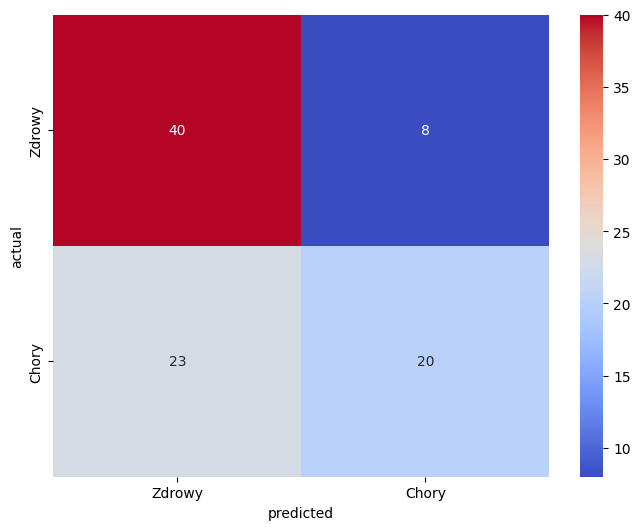

In [274]:
from sklearn.svm import SVC


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc)


show_confusion_matrix(confusion_matrix(y_test, y_pred_svc), ['Zdrowy', 'Chory'])
print(f"Dokładność: {accuracy_svc:.4f}")
print(f"Precycja: {precision_svc:.4f}")
print(f"F1-score: {f1_svc:.4f}")

Dokładność: 0.8352
Precycja: 0.8043
F1-score: 0.8315


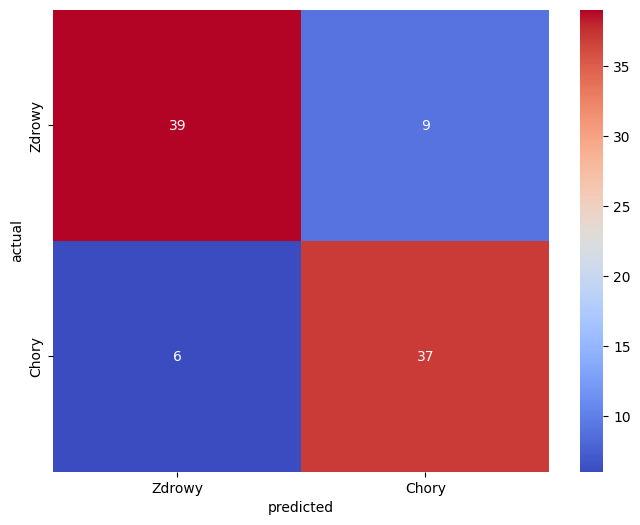

In [275]:

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

show_confusion_matrix(confusion_matrix(y_test, y_pred_rf), ['Zdrowy', 'Chory'])
print(f"Dokładność: {accuracy_rf:.4f}")
print(f"Precycja: {precision_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")

### Wniosek
RandomForrestClassifier poradził sobie dużo lepiej niż SVC <br> <br>


Kontynuujmy eksplorację drzew decyzyjnych <br>
Znajdzmy optymalną głębokość drzewa za pomocą GridSearch

In [282]:
# wagi cech w modelu lasu decyzyjego
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)

     Feature  Importance
11        ca        0.14
2         cp        0.13
7    thalach        0.12
0        age        0.10
12      thal        0.09
9    oldpeak        0.09
4       chol        0.08
3   trestbps        0.07
8      exang        0.06
1        sex        0.04
10     slope        0.04
6    restecg        0.02
5        fbs        0.01


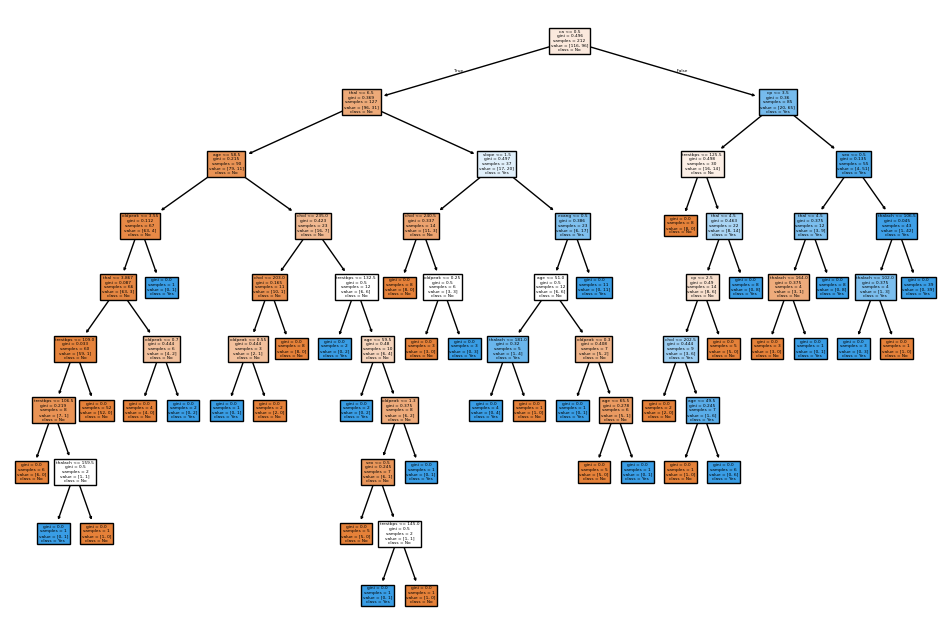

In [283]:

# Wizualizacja pojedyńczego drzewa decyzyjnego

plt.figure(figsize=(12,8))
plot_tree(dt_gini, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)
plt.show()


TUTAJ POCZĄTEK

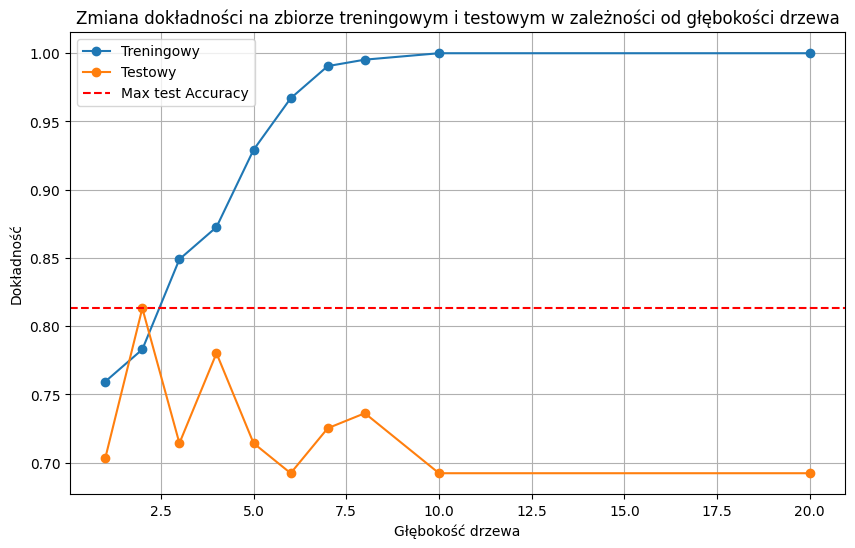

DecisionTreeClassifier(max_depth=2, random_state=42)

In [284]:

X_train, X_test, y_train, y_test

# Lista wartości max_depth do przetestowania
depths = [1, 2, 3, 4, 5, 6, 7, 8, 10, 20, None] # do 11 poziomów głębokości drzewa

# Przechowywanie wyników
train_accuracies = []
test_accuracies = []

# Trening modelu dla różnych wartości max_depth
for depth in depths:
    # Tworzenie i trenowanie modelu drzewa decyzyjnego
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    # Obliczanie dokładności na zbiorze treningowym i testowym
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    # Dodawanie wyników do list
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Wizualizacja wyników
plt.figure(figsize=(10, 6))
plt.plot(depths[:-1], train_accuracies[:-1], marker='o', label='Treningowy')
plt.plot(depths[:-1], test_accuracies[:-1], marker='o', label='Testowy')
plt.axhline(y=max(test_accuracies), color='r', linestyle='--', label='Max test Accuracy')
plt.xlabel('Głębokość drzewa')
plt.ylabel('Dokładność')
plt.title('Zmiana dokładności na zbiorze treningowym i testowym w zależności od głębokości drzewa')
plt.legend()
plt.grid()
plt.show()

# Znalezienie najlepszej głębokości
best_depth = depths[test_accuracies.index(max(test_accuracies))]
# print(f"Best Max Depth: {}")
# print(f"Train Accuracy: {}")
# print(f"Test Accuracy: {}")

# Wizualizacja drzewa dla najlepszej głębokości
clf_best = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
clf_best.fit(X_train, y_train)


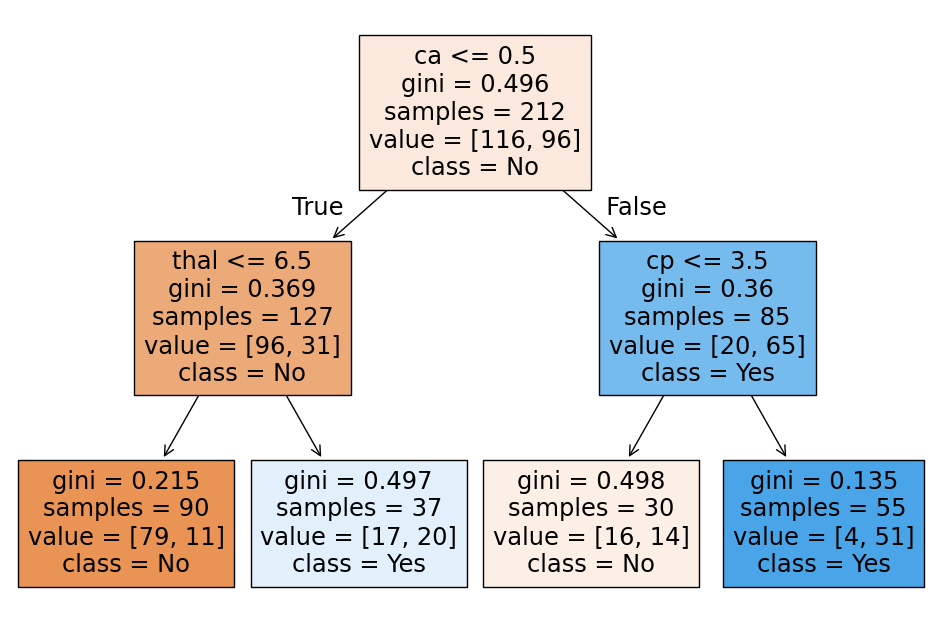

In [285]:
plt.figure(figsize=(12,8))
plot_tree(clf_best, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)
plt.show()

In [286]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Tworzymy model drzewa decyzyjnego (random_state 42)
dt = DecisionTreeClassifier(random_state=42)

# Definiowanie siatki parametrów do przeszukania
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Tworzymy obiekt GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy')

# Przeprowadzamy wyszukiwanie najlepszych parametrów
grid_search.fit(X_train, y_train)

# Wyświetlamy najlepsze parametry i wyniki
print(f"Najlepsze parametry: {grid_search.best_params_}")
print(f"Najlepszy wynik (accuracy): {grid_search.best_score_:.4f}")

# Sprawdzamy model na danych testowych
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Wyświetlamy raport klasyfikacji
print("\nRaport klasyfikacji na danych testowych:")
print(classification_report(y_test, y_pred))

# Można również sprawdzić dokładność
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność na zbiorze testowym: {accuracy:.4f}")


Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 20}
Najlepszy wynik (accuracy): 0.8064

Raport klasyfikacji na danych testowych:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83        48
           1       0.88      0.67      0.76        43

    accuracy                           0.80        91
   macro avg       0.82      0.80      0.80        91
weighted avg       0.82      0.80      0.80        91

Dokładność na zbiorze testowym: 0.8022


In [287]:
# Trening drzewa decyzyjnego z indeksem Giniego
dt_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_gini.fit(X_train, y_train)
score_gini = dt_gini.score(X_test, y_test)

# Trening drzewa decyzyjnego z entropią
dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_entropy.fit(X_train, y_train)
score_entropy = dt_entropy.score(X_test, y_test)

print(f"Dokładność (Gini): {score_gini:.4f}")
print(f"Dokładność (Entropia): {score_entropy:.4f}")

Dokładność (Gini): 0.6923
Dokładność (Entropia): 0.7582


Model drzewa decyzyjnego ztunowano hiperparametry